# <span style="color: orange;">Hidden Markov Model for Detecting Regime Change in Trading</span> 

##  <span style="color: orange;"> Mathematical Structure of the Hidden Markov Model</span> 

1. Hidden States $Z_t$

Let $Z_t$ denote the hidden state at time $t$, which represents the market regime at time $t$. We assume there are $n$ possible hidden states corresponding to different market regimes, i.e.,

$$
Z_{\mathrm{t}} \in\{1,2, \ldots, n\}
$$

where each $Z_t$ corresponds to a market regime (e.g., bull, bear, neutral).
2. Observations $X_t$

$$
P\left(X_t \mid Z_t=k\right)=\mathcal{N}\left(X_t \mid \mu_k, \Sigma_k\right)
$$

where:
- $\mu_k$ is the mean return for regime $k$,
- $\Sigma_k$ is the covariance (or variance if 1D) of the observations in state $k$.
3. Transition Probabilities $A$

$$
A_{i j}=P\left(Z_{t+1}=j \mid Z_t=i\right)
$$


The matrix $A$ must satisfy the following condition:

$$
\sum_{j=1}^n A_{i j}=1 \quad \text { for all } \quad i \in\{1,2, \ldots, n\}
$$

4. Initial State Probabilities $\pi$

The initial state probability vector $\pi=\left[\pi_1, \pi_2, \ldots, \pi_n\right]$ represents the probability of starting in each state. It is a probability distribution, so:

$$
\sum_{i=1}^n \pi_i=1
$$

where $\pi_i=P\left(Z_0=i\right)$.
5. Training the HMM: Baum-Welch Algorithm
- E-Step: Compute the expected values of the hidden states $Z_t$ given the observations $X_1, X_2, \ldots, X_T$, and the current estimates of the model parameters.

We compute the forward and backward probabilities:
- Forward variable $\alpha_t(i)=P\left(X_1, X_2, \ldots, X_t, Z_t=i \mid \theta\right)$
- Backward variable $\beta_i(i)=P\left(X_{\mathrm{t}+1}, X_{t+2}, \ldots, X_T \mid Z_t=i, \theta\right)$
- M-Step: Update the parameters $\mu_k, \Sigma_k, A_{i j}$, and $\pi_i$ using the expected values computed in the E -step:
- Update the transition matrix $A$ using the expected transitions between states:

$$
A_{i j}=\frac{\sum_{t=1}^{T-1} \gamma_t(i, j)}{\sum_{t=1}^{T-1} \gamma_t(i)}
$$

where $\gamma(i, j)$ is the probability of transitioning from state $i$ to state $j$ at time $t$.
- Update the emission parameters $\mu_k$ and $\Sigma_k$ using the expected observations given the hidden states:

$$
\mu_k=\frac{\sum_{t-1}^T \gamma_t(k) X_t}{\sum_{t-1}^T \gamma_t(k)}, \quad \sum_k=\frac{\sum_{t-1}^T \gamma_{\mathrm{t}}(k)\left(X_t-\mu_k\right)\left(X_t-\mu_k\right)^T}{\sum_{t-1}^T \gamma_{\mathrm{t}}(k)}
$$

- Update the initial state probabilities $\pi$ using:

$$
\pi_i=\gamma_1(i)
$$

where $\gamma_1(i)$ is the probability of starting in state $i$. These steps are iteratively applied until the model parameters converge. 6. Classifying Market Regimes: Viterbi Algorithm
Once the model parameters are trained, we use the Viterbi algorithm to classify the most likely sequence of hidden states $Z_1, Z_2, \ldots, Z_T$ given the observed data $X_1, X_2, \ldots, X_T$.
The Viterbi algorithm finds the most probable sequence of hidden states by maximizing the joint probability:

$$
\hat{Z}_1, \hat{Z}_2, \ldots, \hat{Z}_T=\arg _{Z_1, Z_2, \ldots, Z_T} P\left(Z_1, Z_2, \ldots, Z_T \mid X_1, X_2, \ldots, X_T\right)
$$


This can be done recursively using dynamic programming. The probability of the most likely state sequence up to time $t$ for each state $i$ is:

$$
\delta_t(i)=\max _{Z_1, Z_2, \ldots, Z_{2-1}} P\left(Z_1, Z_2, \ldots, Z_t=i \mid X_1, X_2, \ldots, X_t\right)
$$


The Viterbi algorithm efficiently computes this using:

$$
\delta_t(i)=\max _j\left(\delta_{t-1}(j) A_{j i}\right) P\left(X_t \mid Z_t=i\right)
$$

and the corresponding backtracking to recover the sequence of most likely hidden states $Z_1, Z_2, \ldots, Z_T$.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, pacf , acf
from hmmlearn.hmm import GaussianHMM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
from datetime import datetime

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

# Charger les données 1-minute
df = pd.read_csv("btcusd_1-min_data.csv")

# Convertir timestamp UNIX → datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

# Mettre Timestamp en index
df = df.set_index("Timestamp")

# Conversion en données journalières
df_daily = df.resample("1D").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
})

# Supprimer les jours vides (si nécessaire)
df_daily = df_daily.dropna(subset=["Open"])

# Remettre l'index en colonne et l'appeler "Date"
df_daily = df_daily.reset_index()
df_daily = df_daily.rename(columns={"Timestamp": "Date"})

# 3. On garde ce qui t'intéresse (sur les données journalières)
df = df_daily[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()

# 4. Calcul du rendement en % (comme ton "Change %")
df["Change %"] = df["Close"].pct_change() * 100

df.head()


,Date,Open,High,Low,Close,Volume,Change %
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,NaN
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,3.305785
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,5.800000
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,5.293006
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,15.260323


In [6]:
#df = pd.read_csv("gold_prices.csv", delimiter=";")
#df


In [7]:
df["log-return"]= np.log(df["Close"]).diff()
df

,Date,Open,High,Low,Close,Volume,Change %,log-return
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,NaN,NaN
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,3.305785,0.032523
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,5.800000,0.056380
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,5.293006,0.051577
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,15.260323,0.142023
...,...,...,...,...,...,...,...,...
5036,2025-10-15,113077.00,113655.00,110217.00,110804.00,2023.013673,-2.011001,-0.020315
5037,2025-10-16,110804.00,112012.00,107450.00,108206.00,3004.368331,-2.344681,-0.023726
5038,2025-10-17,108206.00,109261.00,103530.00,106476.00,4616.539284,-1.598802,-0.016117
5039,2025-10-18,106470.00,107534.00,106368.00,107220.00,852.542143,0.698749,0.006963


In [8]:
# Filter from 2021-01-01 to today
start_date = "2021-01-01"
end_date = datetime.today()
df_filtered = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
df_filtered= df_filtered.copy()
df_filtered

,Date,Open,High,Low,Close,Volume,Change %,log-return
3288,2021-01-01,28912.47,29700.00,28720.00,29130.21,9211.491621,0.723454,0.007208
3289,2021-01-02,29131.88,33333.00,28947.70,33026.28,13444.106964,13.374672,0.125528
3290,2021-01-03,33032.97,34800.00,30000.00,32759.78,17953.046058,-0.806933,-0.008102
3291,2021-01-04,32758.87,33872.26,27734.00,31172.41,22515.069434,-4.845484,-0.049668
3292,2021-01-05,31179.50,33518.77,29936.26,33467.68,12973.909376,7.363146,0.071047
...,...,...,...,...,...,...,...,...
5036,2025-10-15,113077.00,113655.00,110217.00,110804.00,2023.013673,-2.011001,-0.020315
5037,2025-10-16,110804.00,112012.00,107450.00,108206.00,3004.368331,-2.344681,-0.023726
5038,2025-10-17,108206.00,109261.00,103530.00,106476.00,4616.539284,-1.598802,-0.016117
5039,2025-10-18,106470.00,107534.00,106368.00,107220.00,852.542143,0.698749,0.006963


In [9]:
df_filtered['Change %'] = df["Close"].pct_change()* 100


In [10]:
df_filtered.dropna(inplace=True)

In [11]:
df_filtered.reset_index(inplace=True)

In [12]:
df_filtered = df_filtered.sort_values(by="Date")


In [13]:
df_filtered

,index,Date,Open,High,Low,Close,Volume,Change %,log-return
0,3288,2021-01-01,28912.47,29700.00,28720.00,29130.21,9211.491621,0.723454,0.007208
1,3289,2021-01-02,29131.88,33333.00,28947.70,33026.28,13444.106964,13.374672,0.125528
2,3290,2021-01-03,33032.97,34800.00,30000.00,32759.78,17953.046058,-0.806933,-0.008102
3,3291,2021-01-04,32758.87,33872.26,27734.00,31172.41,22515.069434,-4.845484,-0.049668
4,3292,2021-01-05,31179.50,33518.77,29936.26,33467.68,12973.909376,7.363146,0.071047
...,...,...,...,...,...,...,...,...,...
1748,5036,2025-10-15,113077.00,113655.00,110217.00,110804.00,2023.013673,-2.011001,-0.020315
1749,5037,2025-10-16,110804.00,112012.00,107450.00,108206.00,3004.368331,-2.344681,-0.023726
1750,5038,2025-10-17,108206.00,109261.00,103530.00,106476.00,4616.539284,-1.598802,-0.016117
1751,5039,2025-10-18,106470.00,107534.00,106368.00,107220.00,852.542143,0.698749,0.006963


In [14]:
df_filtered.drop(columns=["index"], inplace=True)

In [15]:
df_filtered.drop(columns=["Volume"], inplace=True)
df_filtered

,Date,Open,High,Low,Close,Change %,log-return
0,2021-01-01,28912.47,29700.00,28720.00,29130.21,0.723454,0.007208
1,2021-01-02,29131.88,33333.00,28947.70,33026.28,13.374672,0.125528
2,2021-01-03,33032.97,34800.00,30000.00,32759.78,-0.806933,-0.008102
3,2021-01-04,32758.87,33872.26,27734.00,31172.41,-4.845484,-0.049668
4,2021-01-05,31179.50,33518.77,29936.26,33467.68,7.363146,0.071047
...,...,...,...,...,...,...,...
1748,2025-10-15,113077.00,113655.00,110217.00,110804.00,-2.011001,-0.020315
1749,2025-10-16,110804.00,112012.00,107450.00,108206.00,-2.344681,-0.023726
1750,2025-10-17,108206.00,109261.00,103530.00,106476.00,-1.598802,-0.016117
1751,2025-10-18,106470.00,107534.00,106368.00,107220.00,0.698749,0.006963


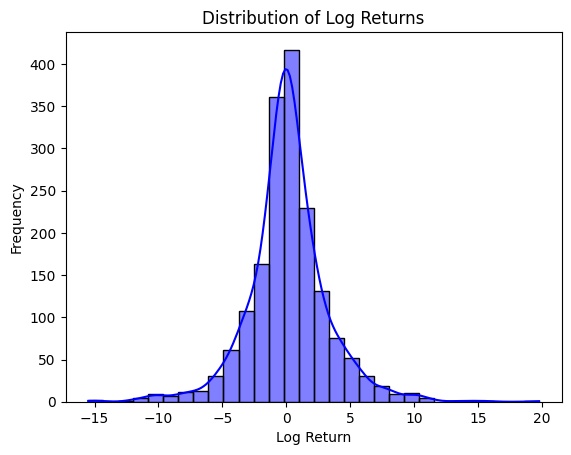

In [18]:
sns.histplot(df_filtered['Change %'], kde=True, color='blue', bins=30)
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()

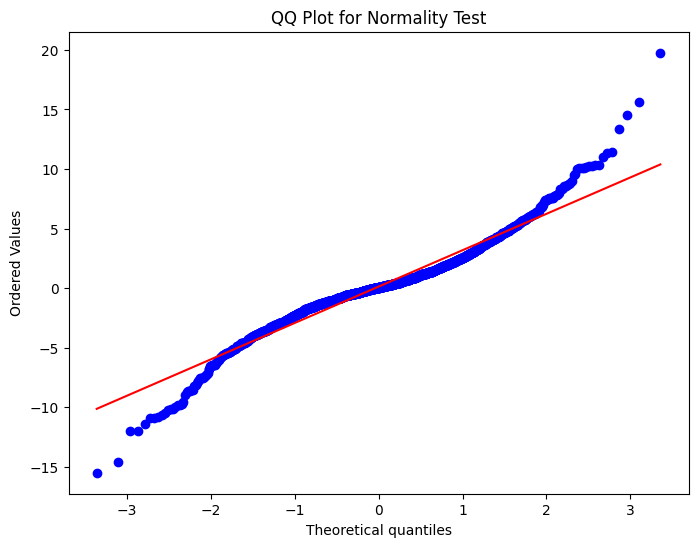

In [19]:
plt.figure(figsize=(8, 6))
stats.probplot(df_filtered['Change %'], dist="norm", plot=plt)
plt.title('QQ Plot for Normality Test')
plt.show()

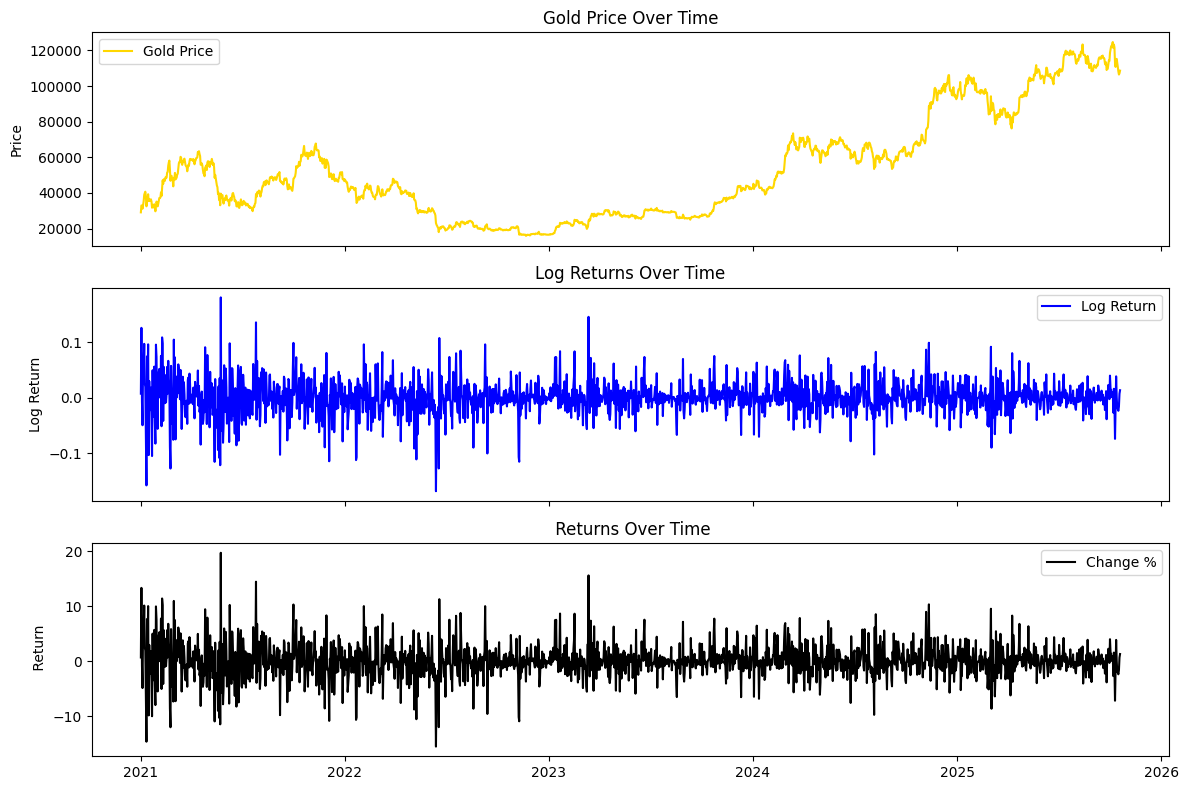

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df_filtered['Date'], df_filtered['Close'], label='Gold Price', color='gold')
axes[0].set_title('Gold Price Over Time')
axes[0].set_ylabel('Price')
axes[0].legend()


axes[1].plot(df_filtered['Date'], df_filtered['log-return'], label='Log Return', color='blue')
axes[1].set_title('Log Returns Over Time')
axes[1].set_ylabel('Log Return')
axes[1].legend()

axes[2].plot(df_filtered['Date'], df_filtered['Change %'], label='Change %', color='black')
axes[2].set_title(' Returns Over Time')
axes[2].set_ylabel(' Return')
axes[2].legend()

plt.tight_layout()
plt.show()

In [21]:
result = adfuller(df_filtered['Change %'])
print("result:", result)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

result: (np.float64(-12.306531327337648), np.float64(7.250298695363593e-23), 10, 1742, {'1%': np.float64(-3.4341094501874854), '5%': np.float64(-2.8632005876775297), '10%': np.float64(-2.567654048515701)}, np.float64(8751.501486743415))
ADF Statistic: -12.306531327337648
p-value: 7.250298695363593e-23
Critical Values: {'1%': np.float64(-3.4341094501874854), '5%': np.float64(-2.8632005876775297), '10%': np.float64(-2.567654048515701)}
The time series is stationary.


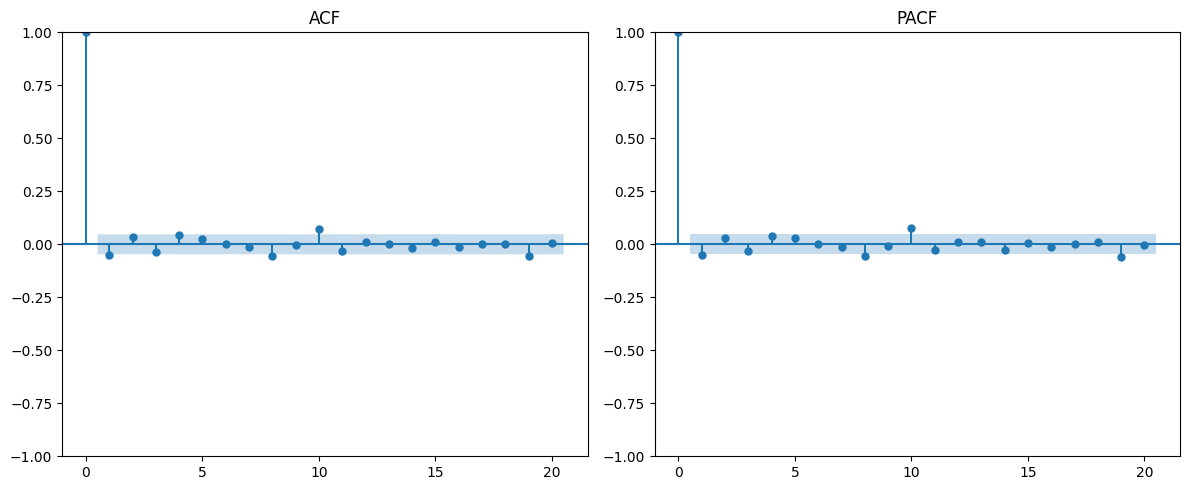

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_filtered['Change %'], ax=axes[0], lags=20)
plot_pacf(df_filtered['Change %'], ax=axes[1], lags=20)
axes[0].set_title('ACF')
axes[1].set_title('PACF')
plt.tight_layout()
plt.show()

In [23]:
split_index = int(0.8 * len(df_filtered))  # 80% training, 20% testing
train_data = df_filtered[:split_index]
test_data = df_filtered[split_index:]

observations = df_filtered["Change %"].values.reshape(-1,1)
train_observation= train_data["Change %"].values.reshape(-1,1)
test_observation= test_data["Change %"].values.reshape(-1,1)

In [24]:
train_data

,Date,Open,High,Low,Close,Change %,log-return
0,2021-01-01,28912.47,29700.00,28720.00,29130.21,0.723454,0.007208
1,2021-01-02,29131.88,33333.00,28947.70,33026.28,13.374672,0.125528
2,2021-01-03,33032.97,34800.00,30000.00,32759.78,-0.806933,-0.008102
3,2021-01-04,32758.87,33872.26,27734.00,31172.41,-4.845484,-0.049668
4,2021-01-05,31179.50,33518.77,29936.26,33467.68,7.363146,0.071047
...,...,...,...,...,...,...,...
1397,2024-10-29,69918.00,73600.00,69716.00,72729.00,4.020424,0.039417
1398,2024-10-30,72727.00,72928.00,71313.00,72331.00,-0.547237,-0.005487
1399,2024-10-31,72330.00,72660.00,69591.00,70231.00,-2.903319,-0.029463
1400,2024-11-01,70202.00,71596.00,68768.00,69490.00,-1.055090,-0.010607


10276871.020912634
9858128.828946145
9730591.49492727
9714928.045874821
9710824.944245283


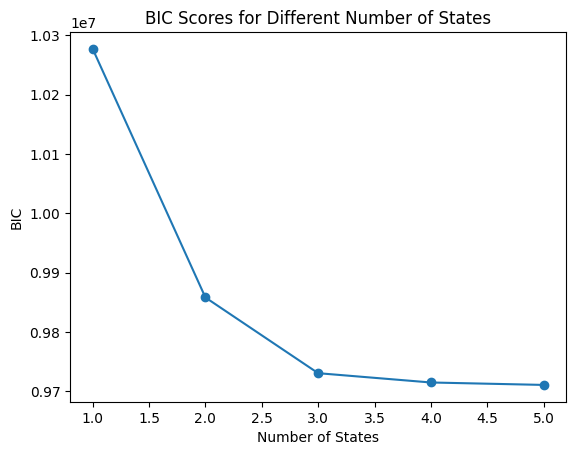

In [25]:
bic_scores = []
n_features = 1

for n in range(1, 6):  # Test 1 to 5 states
    k = n * n_features * 2 + n * (n - 1)
    model = GaussianHMM(n_components=n, covariance_type='diag', n_iter=1000, tol=1e-02, random_state=42)
    model.fit(train_observation)
    logL = model.score(train_observation) * len(train_observation)
    bic = -2 * logL + k * np.log(len(train_observation))
    print(bic)
    bic_scores.append(bic)

# Plot BIC scores
plt.plot(range(1, 6), bic_scores, marker='o')
plt.title('BIC Scores for Different Number of States')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.show()

In [26]:
n_states=4
hmm_model = GaussianHMM(n_components=n_states, covariance_type='spherical', n_iter=1000, tol=1e-2, random_state=42)
hmm_model.fit(train_observation) 

,n_components,4
,covariance_type,'spherical'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [27]:
hidden_states = hmm_model.predict(train_observation)

train_data = train_data.copy()
train_data.loc[:, "hidden_states"] = hidden_states
log_likelihood = hmm_model.score(test_observation)
print("Log-likelihood on testing data:", log_likelihood)

Log-likelihood on testing data: -775.5600564934074


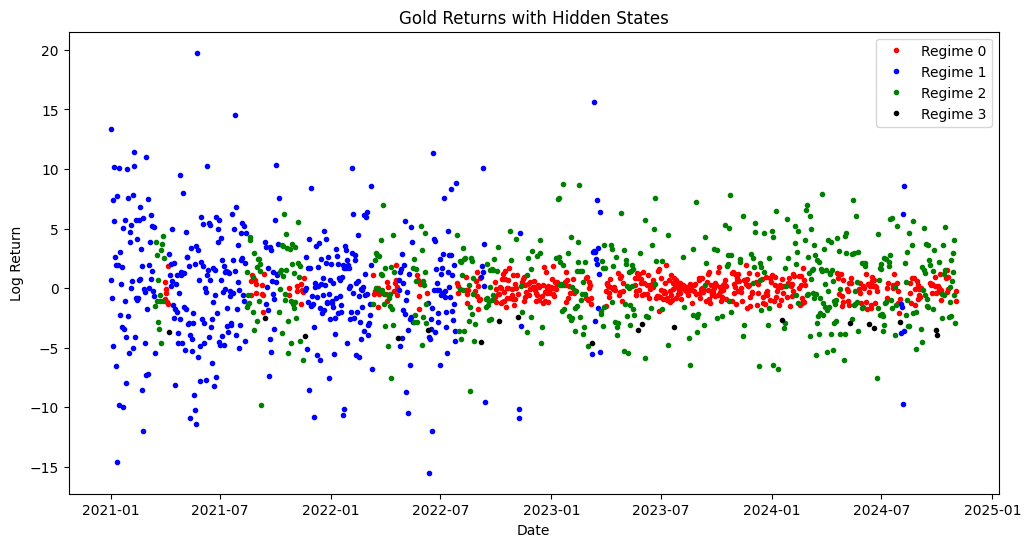

In [28]:
# Plot log-returns with hidden states
plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'green', "black", "gold"]
for state in range(n_states):
    plt.plot(train_data['Date'][train_data['hidden_states'] == state],
             train_data['Change %'][train_data['hidden_states'] == state],
             '.', label=f'Regime {state}', color=colors[state])
plt.title('Gold Returns with Hidden States')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

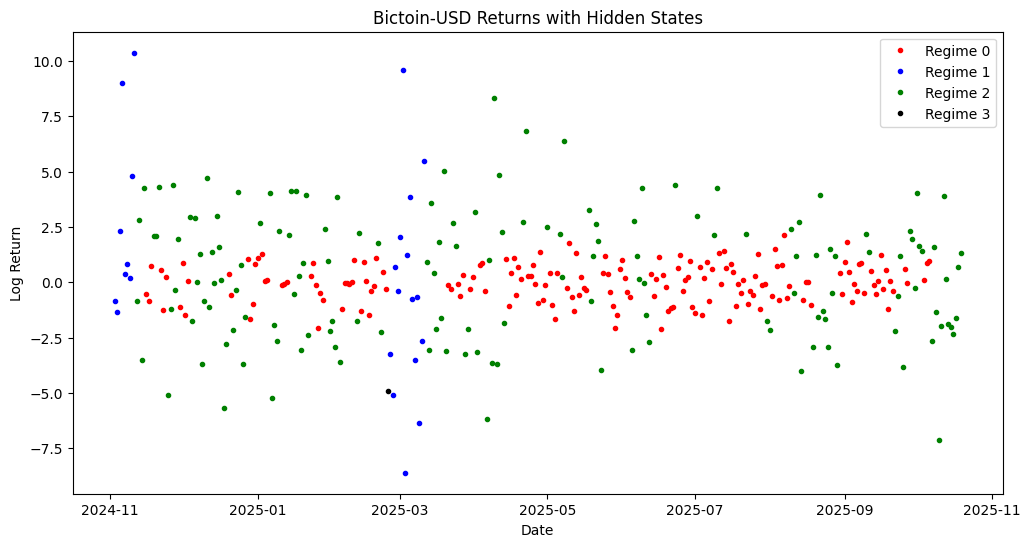

In [30]:
# Plot log-returns with hidden states
hidden_states = hmm_model.predict(test_observation)
test_data = test_data.copy()

test_data.loc[:, "hidden_states"]=hidden_states 

plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'green', "black", "gold"]
for state in range(n_states):
    plt.plot(test_data['Date'][test_data.loc[:, 'hidden_states'] == state],
             test_data['Change %'][test_data.loc[:, 'hidden_states'] == state],
             '.', label=f'Regime {state}', color=colors[state])
plt.title('Bictoin-USD Returns with Hidden States')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [31]:
print("Transition Matrix:")
print(hmm_model.transmat_)

print("\nMeans and Covariances of each state:")
for i in range(n_states):
    print(f"State {i}: Mean = {hmm_model.means_[i][0]}, Variance = {hmm_model.covars_[i][0]}")

Transition Matrix:
[[6.05243865e-01 4.12263420e-12 3.44399639e-01 5.03564963e-02]
 [1.45208121e-09 9.42846920e-01 5.71524119e-02 6.66852786e-07]
 [2.54734549e-01 8.48395910e-05 7.44919967e-01 2.60644733e-04]
 [3.85358703e-01 4.60435961e-01 3.04613359e-02 1.23744000e-01]]

Means and Covariances of each state:
State 0: Mean = -0.032024698046126295, Variance = [0.86247379]
State 1: Mean = 0.14205962091313074, Variance = [32.00212751]
State 2: Mean = 0.3359102944839407, Variance = [10.44471261]
State 3: Mean = -3.080321118092558, Variance = [0.80995793]


# Regime Characteristics Table

| Regime | Characteristics | Volatility | Return Range | Interpretation |
| :--- | :--- | :--- | :--- | :--- |
| Regime 0 (Red) | High positive returns with moderate spread | Moderate | Positive | Bullish market or growth periods. |
| Regime 2 (Green) | Stable returns centered near zero, minimal spread | Low | Around zero | Market stability or periods of consolidation. |
| Regime 1 (Blue) | Low returns, mostly negative, tight clustering | Low | Negative | Bearish market or declining conditions. |
| Regime 3 (Black) | Extreme negative returns with high spread | High | Large negative | Outliers or rare unusual conditions. |

In [32]:
df_filtered = pd.concat([train_data,test_data])
df_filtered

,Date,Open,High,Low,Close,Change %,log-return,hidden_states
0,2021-01-01,28912.47,29700.00,28720.00,29130.21,0.723454,0.007208,1
1,2021-01-02,29131.88,33333.00,28947.70,33026.28,13.374672,0.125528,1
2,2021-01-03,33032.97,34800.00,30000.00,32759.78,-0.806933,-0.008102,1
3,2021-01-04,32758.87,33872.26,27734.00,31172.41,-4.845484,-0.049668,1
4,2021-01-05,31179.50,33518.77,29936.26,33467.68,7.363146,0.071047,1
...,...,...,...,...,...,...,...,...
1748,2025-10-15,113077.00,113655.00,110217.00,110804.00,-2.011001,-0.020315,2
1749,2025-10-16,110804.00,112012.00,107450.00,108206.00,-2.344681,-0.023726,2
1750,2025-10-17,108206.00,109261.00,103530.00,106476.00,-1.598802,-0.016117,2
1751,2025-10-18,106470.00,107534.00,106368.00,107220.00,0.698749,0.006963,2


In [33]:
initial_value = 1000
risk_free_rate =0.03
transaction_cost = 0.004  # 0.1% transaction cost per switch
portfolio_values = [initial_value] 

for i in range(1, len(df_filtered.Close)):
    if df_filtered["hidden_states"].iloc[i]==0 or df_filtered["hidden_states"].iloc[i]==1 or df_filtered["hidden_states"].iloc[i]==3:
        allocation = 0 # high risk 
        portfolio_value = portfolio_values[-1]*(1+risk_free_rate/252)
    
    elif df_filtered["hidden_states"].iloc[i]==2:
        if df_filtered["Change %"].iloc[i]>0 : 
            allocation = 0 # negative return
            portfolio_value = portfolio_values[-1]*(1+df_filtered["Change %"].iloc[i]/100)
        elif df_filtered["Change %"].iloc[i]< 0:
            portfolio_value = portfolio_values[-1]*(1+risk_free_rate/252)

    if df_filtered["hidden_states"].iloc[i-1] in [0,1,3] and df_filtered["hidden_states"].iloc[i]==2 or df_filtered["hidden_states"].iloc[i-1]==2 and df_filtered["hidden_states"].iloc[i] in [0,1,3]:
        portfolio_value-= portfolio_values[-1]* transaction_cost

    portfolio_values.append(portfolio_value)
    
df_filtered["portfolio_values"] = portfolio_values

# Interpretation of the Strategy
- In high-risk states $(0,1,3)$, the portfolio avoids the market entirely, earning the risk-free rate.
- In state 2, the portfolio participates in the market, but only during positive returns (Change \% > 0).
- Negative returns in state 2 trigger a shift back to cash.

Transaction Costs:
- Frequent hidden state changes can erode the portfolio's performance due to transaction costs.
- Overall Objective:

This strategy appears defensive, prioritizing capital preservation in risky conditions while attempting to capture gains in favorable market conditions.

In [34]:
df_filtered["Buy_hold_strategy"] = initial_value*(df_filtered["Close"]/df_filtered["Close"].iloc[0])


In [35]:
df_filtered


,Date,Open,High,Low,Close,Change %,log-return,hidden_states,portfolio_values,Buy_hold_strategy
0,2021-01-01,28912.47,29700.00,28720.00,29130.21,0.723454,0.007208,1,1.000000e+03,1000.000000
1,2021-01-02,29131.88,33333.00,28947.70,33026.28,13.374672,0.125528,1,1.000119e+03,1133.746719
2,2021-01-03,33032.97,34800.00,30000.00,32759.78,-0.806933,-0.008102,1,1.000238e+03,1124.598141
3,2021-01-04,32758.87,33872.26,27734.00,31172.41,-4.845484,-0.049668,1,1.000357e+03,1070.105914
4,2021-01-05,31179.50,33518.77,29936.26,33467.68,7.363146,0.071047,1,1.000476e+03,1148.899373
...,...,...,...,...,...,...,...,...,...,...
1748,2025-10-15,113077.00,113655.00,110217.00,110804.00,-2.011001,-0.020315,2,4.644862e+06,3803.748754
1749,2025-10-16,110804.00,112012.00,107450.00,108206.00,-2.344681,-0.023726,2,4.645415e+06,3714.562991
1750,2025-10-17,108206.00,109261.00,103530.00,106476.00,-1.598802,-0.016117,2,4.645968e+06,3655.174474
1751,2025-10-18,106470.00,107534.00,106368.00,107220.00,0.698749,0.006963,2,4.678431e+06,3680.714969


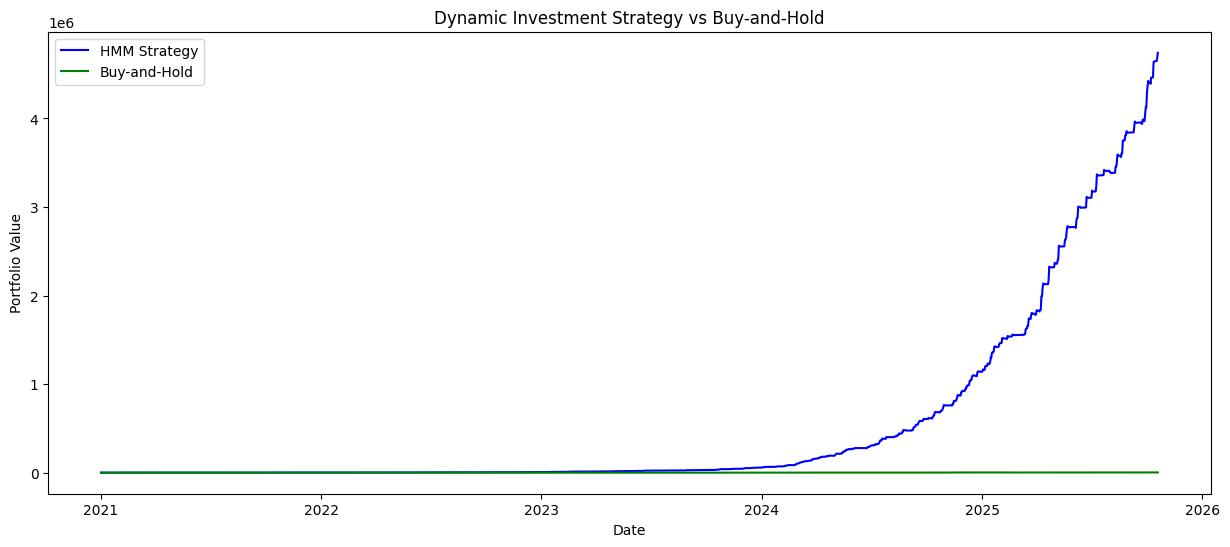

In [36]:
# Step 4: Plot Results
plt.figure(figsize=(15, 6))
plt.plot(df_filtered['Date'], df_filtered['portfolio_values'], label='HMM Strategy', color='blue')
plt.plot(df_filtered['Date'], df_filtered['Buy_hold_strategy'], label='Buy-and-Hold', color='green')
plt.title("Dynamic Investment Strategy vs Buy-and-Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

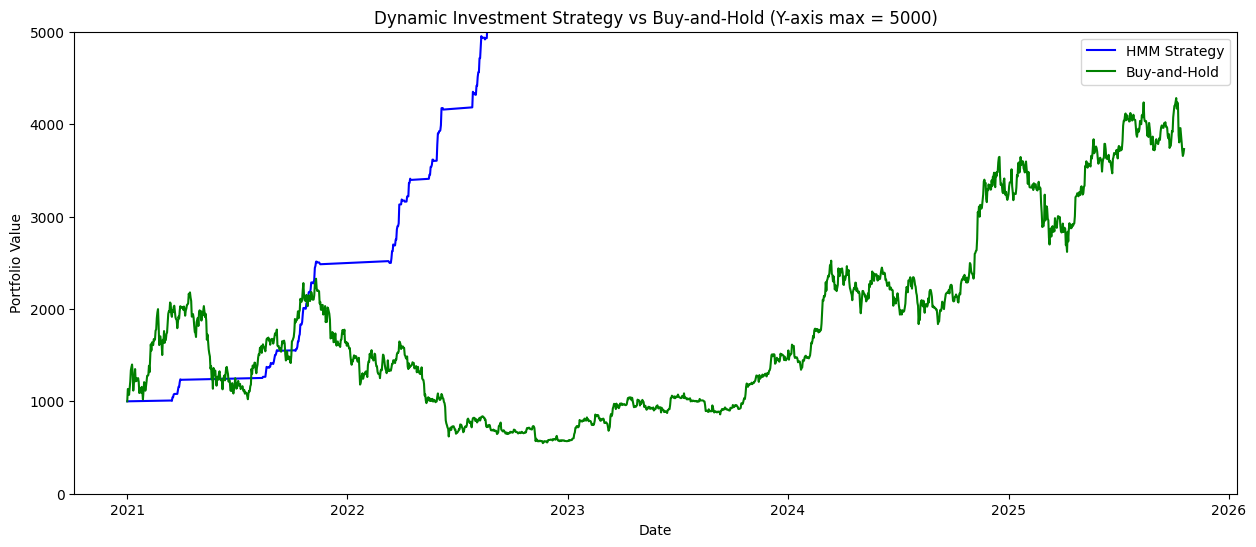

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(df_filtered['Date'], df_filtered['portfolio_values'], label='HMM Strategy', color='blue')
plt.plot(df_filtered['Date'], df_filtered['Buy_hold_strategy'], label='Buy-and-Hold', color='green')
plt.title("Dynamic Investment Strategy vs Buy-and-Hold (Y-axis max = 5000)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.ylim(0, 5000)  # Limit y-axis between 0 and 5000
plt.legend()
plt.show()


In [38]:
strategy_returns  = np.log(df_filtered["portfolio_values"]).diff().dropna()
buy_hold_returns= np.log(df_filtered["Buy_hold_strategy"]).diff().dropna()
# Step 5: Calculate Sharpe Ratios
strategy_sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
buy_hold_sharpe = buy_hold_returns.mean() / buy_hold_returns.std() * np.sqrt(252)

print(f"Sharpe Ratio (HMM Strategy): {strategy_sharpe:.2f}")
print(f"Sharpe Ratio (Buy-and-Hold): {buy_hold_sharpe:.2f}")

Sharpe Ratio (HMM Strategy): 5.93
Sharpe Ratio (Buy-and-Hold): 0.38


# RSA trading strategy 

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1748    1.214466
1749    1.214466
1750    1.214466
1751    1.214466
1752    1.214466
Name: Strategy_Return, Length: 1753, dtype: float64

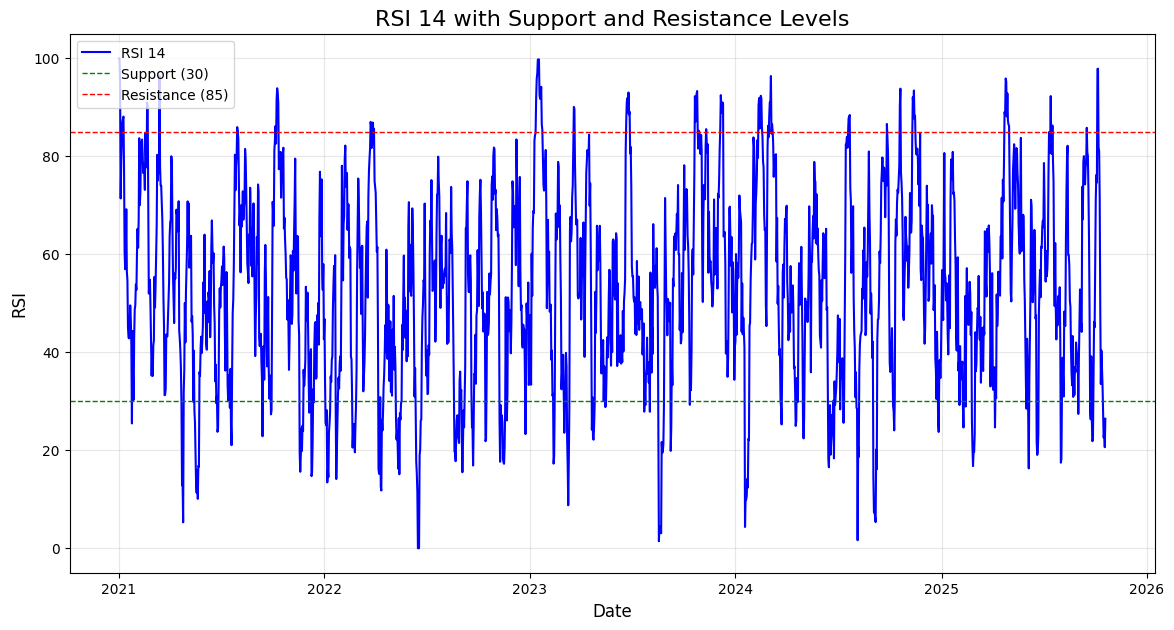

In [39]:
# Calculate gains and losses
df_filtered['Gain'] = np.where(df_filtered['Change %'] > 0, df_filtered['Change %'], 0)
df_filtered['Loss'] = np.where(df_filtered['Change %'] < 0, -df_filtered['Change %'], 0)
# Calculate average gain and loss (14-period)
window = 10
df_filtered['Avg_Gain'] = df_filtered['Gain'].rolling(window=window, min_periods=1).mean()
df_filtered['Avg_Loss'] = df_filtered['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate RSI
df_filtered['RS'] = df_filtered['Avg_Gain'] / df_filtered['Avg_Loss']
df_filtered['RSI'] = 100 - (100 / (1 + df_filtered['RS']))

plt.figure(figsize=(14, 7))
plt.plot(df_filtered['Date'], df_filtered['RSI'], label='RSI 14', color='blue', linewidth=1.5)

# Add support and resistance levels
plt.axhline(y=30, color='green', linestyle='--', linewidth=1, label='Support (30)')
plt.axhline(y=85, color='red', linestyle='--', linewidth=1, label='Resistance (85)')

# Add title and labels
plt.title('RSI 14 with Support and Resistance Levels', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI', fontsize=12)

# Add a legend
plt.legend(loc='upper left', fontsize=10)

# Add grid for better readability
plt.grid(alpha=0.3)
df_filtered['Signal'] = np.where(df_filtered['RSI'] < 20, 'Buy', np.where(df_filtered['RSI'] > 90, 'Sell', 'Hold')) 
df_filtered['Position'] = 0  # 1 for holding a long position, 0 for no position
for i in range(1, len(df_filtered)):
    if df_filtered.loc[i, 'Signal'] == 'Buy' and df_filtered.loc[i - 1, 'Position'] == 0:
        df_filtered.loc[i, 'Position'] = 1  # Enter long position
    elif df_filtered.loc[i, 'Signal'] == 'Sell' and df_filtered.loc[i - 1, 'Position'] == 1:
        df_filtered.loc[i, 'Position'] = 0  # Exit long position
    else:
        df_filtered.loc[i, 'Position'] = df_filtered.loc[i - 1, 'Position']  # Hold the current position

df_filtered['Strategy_Return'] = df_filtered['Change %'] * df_filtered['Position']
df_filtered['Strategy_Return'].cumsum()